## Rudimentary Creation and Visualization of Tissot’s Indicatrix for Mercator and Cylindrical Equal Area Projection

_Esmé Middaugh_
_7 March, 2022_

This script allows for the rudimentary visualization of Tissot's Indicatrix for a user defined area of the earth's surface. The original plan was for a script that would work with an input shapefile, but in the end this works at a more abstract level. For the script that works with an input shapefile and also gives an output shapefile, please see _Initial Tissot's Indicatrix Attempt_.

The follow functions are included:

create_graticules - Creates a grid in the latitude longitude space of intersecting meridians and parallels, spaced according to the given merdian and parallel spaces.
plot_grid - plot the graticules
obtain_indicatrix_axis - for a given grid and projection, return the vertical and horizontal axis of a indicatrix

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [78]:
def create_graticules(east_west = [-90,90], north_south=[-82.5, 82.5], meridian_space = 15.0, parallel_space = 15.0):
    """
    Creates a grid in the latitude longitude space of intersecting meridians and parallels, spaced according to the given merdian and parallel spaces.
    
    
    Parameters
    ----------
    east_west: list
        Two item list that contains the west (-) and east bounds to be mapped. 
    north_south: list
        Two item list that contains the south and north bounds to be mapped, defaults to <90 due to mapping. 
    meridian_space = float
        The space between the meridian (vertical) grid lines, in degrees longitude. 
    
    
    Returns 
    -------
    grid: list
        A nested list containing all the meridians and parallels in the format [longitude, latitute]. Each line is a list, so the totlal format is [[[lambda, phi]]] A shortcut for testing purposes. 
    
    """
    meridians = []
    current_meridian = east_west[0]
    while current_meridian < east_west[1]:
        line = []
        for paral in np.arange(north_south[0], north_south[1], parallel_space):
            line.append([current_meridian, paral])
        meridians.append(line)
        current_meridian+=meridian_space
    
    parallels = []
    current_parallel = north_south[0]
    while current_parallel < north_south[1]:
        line = []
        for meridian in np.arange(east_west[0], east_west[1], meridian_space):
            line.append([meridian, current_parallel])
        parallels.append(line)
        current_parallel+=parallel_space
    
    grid = meridians
    grid.extend(parallels)
    return grid


In [79]:
def plot_grid(grid, coord_format="x/y"): 
    """Helper function for graphing the graticules or x & y coordinate lines. If lat/lon map lat to y and lon to x """
    if coord_format=="lat/lon": 
        for line in grid:
            plt.plot([point[1] for point in line], [point[0] for point in line])
    elif coord_format=="x/y":
        for line in grid:
            plt.plot([point[0] for point in line], [point[1] for point in line])  
    plt.show()

In [82]:
def secant(num):
    """ Helper function to eturn secant value of number given in radians (numpy contains no secant)."""
    sec_value = 1 / np.cos(num)
    return sec_value

In [80]:
def mercator(phi_lat, lambda_lon, radius=6378137):
    """For a given point return the mercator projection x and y values at the given radius"""
    r = radius
    x = r * np.radians(lambda_lon) # assuming touching at equator 
    y = r * np.log(np.tan(np.pi / 4 + np.radians(phi_lat) / 2)) #https://kartoweb.itc.nl/geometrics/Map%20projections/body.htm
    return x, y

def cylindrical_equal_area(phi_lat, lambda_lon, radius=6378137): 
    """For a given point return the mercator projection x and y values at the given radius"""
    r = radius
    x = r * np.radians(lambda_lon)
    y = r * np.sin(np.radians(phi_lat))
    return x, y

In [83]:
def transform_grid(grid, projection):
    """ Helper function for demonstration purposes, take a grid and go through and apply a function to each point."""
    new_grid = []
    for line in grid:
        new_line = []
        for point in line:
            x, y = apply_projection(point[0], point[1], projection) 
            new_line.append([x,y])
        new_grid.append(new_line)
    return new_grid

## Obtain Indicatrix Axis

Taken from https://en.wikipedia.org/wiki/Mercator_projection#Mathematics
The Mercator projection is determined by the requirement that the projection be conformal. One implication of this is the "isotropy of scale factors", which means that the point scale factor is independent of direction, so that small shapes are preserved by the projection. This implies that the vertical scale factor, h, equals the horizontal scale factor, k. Since k = sec φ, so must h.

Mercator scale plot.svg
The graph shows the variation of this scale factor with latitude. Some numerical values are listed below.

In [100]:
def obtain_indicatrix_axis(point, projection):
    """
    Obtain the axis of Tissot's Indicatrix at the given point as scale factors h (vertical) and k(horizontal). 
    
    
    Parameters:
    ----------
    Projection
    point - an array composed of [lat, lon] with lat and lon in degrees ranging from -90 to 90 for latitude and -180 to 180 for longitdue
    
    
    Parameters
    ----------
    point: list
        A two item list in the format [longitude, latitude]
        
    projection: function
        The name of a projection function, currently one of one mercator or lambert equal area. 
    
    
    Returns
    ----------
        sf_h - scale factor in the vertical , sized to match the projection
        sf_k - scale factor in the horizontal, sized to match the projection 
    """
    lat = point[1]
    lon = point[0]
    
    x, y = projection(lat, lon)
    
#     # This is where I couldn't get the derivatives to work 
#     h = 10**(-5.2) 
#     x0, y0 = projection(lat - h/2, lon)
#     x1, y1 = projection(lat + h/2, lon)
#     x2, y2 = projection(lat, lon - h/2)
#     x3, y3 = projection(lat, lon + h/2)
    
#     # Partial derivatives with respect to phi(lat) and lambda (lon)
#     dx_phi = (x1 - x0) / h 
#     dy_phi = (y1 - y0) / h
#     dx_lambda = (x3 - x2) / h
#     dy_lambda = (y3 - y2) / h

#     R = 6378137 # for now using world radius of WGS84 https://en.wikipedia.org/wiki/World_Geodetic_System#:~:text=The%20WGS%2084%20datum%20surface,%3D%201%2F298.257223563.
    
#     # General 24, 4-10
#     sf_h = (1/R) * np.sqrt(( np.square((dx_phi)) + np.square((dy_phi)) ))
#     sf_k =  (1/R * np.cos(np.radians(lat))) * ((dx_lambda)**2 + (dy_lambda)**2)**1/2

    
#     # Cylindrical - page 21, 4-2
#     sf_h = dy_phi  * 1/R 
#     sf_k =  dx_lambda * (1/ R * np.cos(lat)) # lat = phi
    
#     # Where I would also need to expand with equation for the angle of distortion
    
    if projection == mercator: 
        sf_h = secant(np.radians(lat))
        sf_k = sf_h 
    
    if projection == cylindrical_equal_area: 
        sf_h = np.cos(np.radians(lat))
        sf_k = 1 / sf_h
    
    return sf_h, sf_k

In [130]:
def plot_tissots_indicatrix(grid, projection): 
    """ For a given grid of meridians and parallels and a projection (currenlty only one of 'mercator' or 'cylindrical_equal_area', create an indicatrix plot with indicatrices scaled to approximately 6% of the graph size."""
    
    plt.clf() # Clear plot
    
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}) # create base graph 
    fig.set_size_inches(10.5, 10.5) # resize 


    R = 6378137 # approx radius of earth
    scale = R * .06

    for line in grid:
        for point in line: 
            x,y = apply_projection(point[1], point[0], projection)
            scale_y, scale_x = obtain_indicatrix_axis(point, projection)
            ellipse = Ellipse((x, y), scale_x * scale, scale_y *scale, alpha=.5)
            ax.add_artist(ellipse)

    transformed_grid = transform_grid(grid, projection)
    
    def calculate_graph_bounds(grid): 
        """ Helper function to ensure that the created TI show up on the graph when using Ellipse and add_artist."""
        min_x = 0 
        max_x = 0 
        min_y = 0 
        max_y = 0 
        for line in grid:
            for point in line:
                if point[0] < min_x:
                    min_x = point[0]
                elif point[0] > max_x:
                    max_x = point[0]
                if point[1] < min_y:
                    min_y = point[1]
                elif point[1] > max_y:
                    max_y = point[1]
        return min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = calculate_graph_bounds(transformed_grid)
    ax.set_xlim(min_x , max_x)
    ax.set_ylim(min_y, max_y)
    plt.axis('off')
    plt.show()

## Demo

Below are small examples of how this script could be called to visualize Tissot's Indicatrix at different user define map levels.

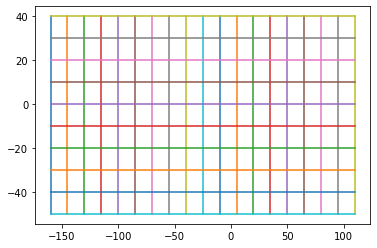

In [131]:
grid = create_graticules(east_west=[-160, 120], north_south=[-50, 50], meridian_space=15, parallel_space = 10.0)
plot_grid(grid)

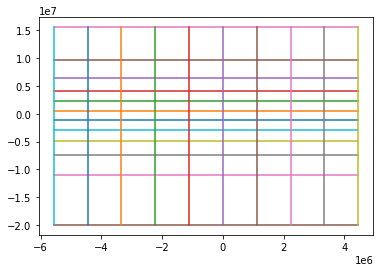

In [132]:
transformed_grid = transform_grid(grid, mercator)
plot_grid(transformed_grid)

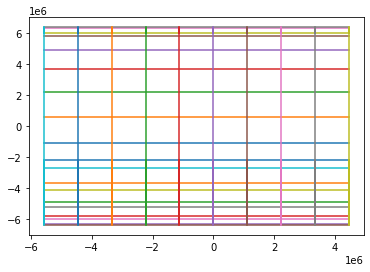

In [133]:
transformed_grid = transform_grid(grid, cylindrical_equal_area)
plot_grid(transformed_grid)

<Figure size 432x288 with 0 Axes>

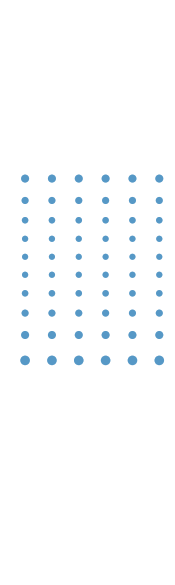

In [134]:
plot_tissots_indicatrix(grid, mercator)

<Figure size 432x288 with 0 Axes>

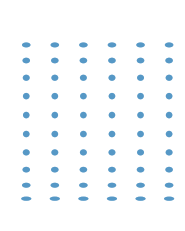

In [122]:
plot_tissots_indicatrix(grid, cylindrical_equal_area)